In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Import 
covid_death_data = pd.read_csv("archive/RAW_global_deaths.csv")
covid_cases_data = pd.read_csv("archive/RAW_global_confirmed_cases.csv")

print(covid_death_data.columns)
print(covid_cases_data.columns)


Index(['Country/Region', 'Province/State', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '2/28/23', '3/1/23', '3/2/23', '3/3/23', '3/4/23', '3/5/23', '3/6/23',
       '3/7/23', '3/8/23', '3/9/23'],
      dtype='object', length=1147)
Index(['Country/Region', 'Province/State', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '2/28/23', '3/1/23', '3/2/23', '3/3/23', '3/4/23', '3/5/23', '3/6/23',
       '3/7/23', '3/8/23', '3/9/23'],
      dtype='object', length=1147)


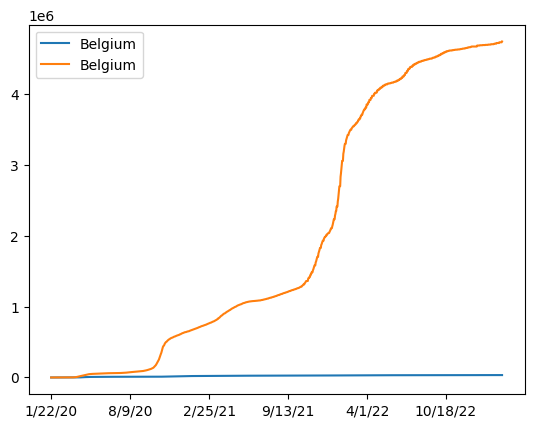

Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antarctica',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       ...
       'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam',
       'West Bank and Gaza', 'Winter Olympics 2022', 'Yemen', 'Zambia',
       'Zimbabwe'],
      dtype='object', name='Country/Region', length=201)


In [8]:
# Data Preprocessing
death_dataframe = covid_death_data.drop(["Province/State", "Lat", "Long"], axis=1)
cases_dataframe = covid_cases_data.drop(["Province/State", "Lat", "Long"], axis=1)

death_agg = death_dataframe.groupby("Country/Region").sum()
cases_agg = cases_dataframe.groupby("Country/Region").sum()

death_agg.loc["Belgium"].plot()
cases_agg.loc["Belgium"].plot()
plt.legend()
plt.show()

print(cases_agg.index)

In [14]:
# Calculate the maximum infection rate per country
max_infection_rates = []

# Iterate over the countries in cases_agg
for country in cases_agg.index:
    max_infection_rate = cases_agg.loc[country].diff().max()
    max_infection_rates.append(max_infection_rate)

# Add the list of maximum infection rates as a new column in cases_agg
cases_agg["max_infection_rate"] = max_infection_rates

# Calculate the maximum death rate per country
max_death_rates = []

# Iterate over the countries in death_agg
for country in death_agg.index:
    max_death_rate = death_agg.loc[country].diff().max()
    max_death_rates.append(max_death_rate)

# Add the list of maximum death rates as a new column in death_agg
death_agg["max_death_rate"] = max_death_rates

# Get the intersection of index labels between cases_agg and death_agg
common_countries = cases_agg.index.intersection(death_agg.index)

# Create a DataFrame containing the maximum rates for each country from both datasets
max_spread_df = pd.DataFrame({
    "Country": common_countries,
    "Max Infection Rate": cases_agg.loc[common_countries, "max_infection_rate"],
    "Max Death Rate": death_agg.loc[common_countries, "max_death_rate"]
})

# Display the DataFrame
print(max_spread_df)

                                   Country  Max Infection Rate  Max Death Rate
Country/Region                                                                
Afghanistan                    Afghanistan              3243.0           159.0
Albania                            Albania              4789.0            21.0
Algeria                            Algeria              2521.0            49.0
Andorra                            Andorra              2313.0             7.0
Angola                              Angola              5035.0            30.0
...                                    ...                 ...             ...
West Bank and Gaza      West Bank and Gaza             30356.0           268.0
Winter Olympics 2022  Winter Olympics 2022                72.0             0.0
Yemen                                Yemen               287.0            60.0
Zambia                              Zambia              5555.0            72.0
Zimbabwe                          Zimbabwe          

In [16]:
# Calculate the correlation matrix
correlation_matrix = max_spread_df.drop(columns='Country').corr()

# Display the correlation matrix
print(correlation_matrix)


                    Max Infection Rate  Max Death Rate
Max Infection Rate            1.000000        0.108238
Max Death Rate                0.108238        1.000000


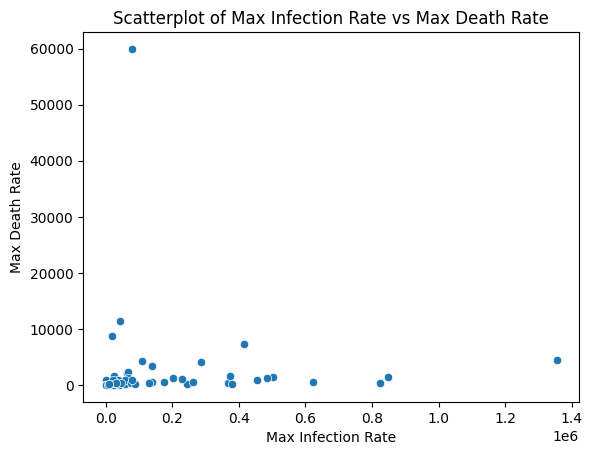

In [21]:
import seaborn as sns
# Scatterplot between Max Infection Rate and Max Death Rate
sns.scatterplot(x=max_spread_df["Max Infection Rate"], y=max_spread_df["Max Death Rate"])
plt.xlabel("Max Infection Rate")
plt.ylabel("Max Death Rate")
plt.title("Scatterplot of Max Infection Rate vs Max Death Rate")
plt.show()


In [23]:
from hmmlearn.hmm import GaussianHMM

# Prepare the data
train_features = max_spread_df[['Max Infection Rate', 'Max Death Rate']].values

# Initialize the Gaussian HMM model
hm = GaussianHMM(n_components=4)

# Fit the model to the training features
hm.fit(train_features)


GaussianHMM(n_components=4)

In [25]:
# Assuming you have max_spread_df as your DataFrame
test_features = max_spread_df[['Max Infection Rate', 'Max Death Rate']].values

# Predict the most likely sequence of hidden states for the test data
predicted_states = hm.predict(test_features)

# Display the predicted states
print(predicted_states)



[0 0 0 0 0 0 0 3 0 3 1 0 0 0 0 0 0 1 0 0 0 1 0 0 3 0 0 0 0 0 0 0 0 1 0 0 3
 3 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 3 0 0 0 0 0 0 0 0 3 1 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 1 0 3 3 1 0 0 3 1 0 1 0 3 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 3 0 1 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 3 3 1 3 1 0 3 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 3 1 0 1 0 3 1 0 0 0 0 0 1
 0 2 3 1 0 1 0 0 0 0 1 0 0 0 0 0]


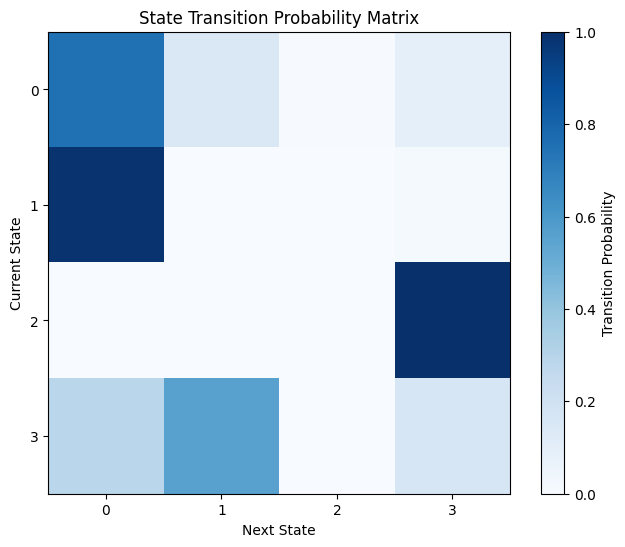

In [27]:
# Get the number of components (states) in the HMM
n_components = hm.n_components

# Plot the transition matrix
plt.figure(figsize=(8, 6))
plt.imshow(transition_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar(label='Transition Probability')
plt.title('State Transition Probability Matrix')
plt.xlabel('Next State')
plt.ylabel('Current State')
plt.xticks(np.arange(n_components), np.arange(n_components))
plt.yticks(np.arange(n_components), np.arange(n_components))
plt.show()


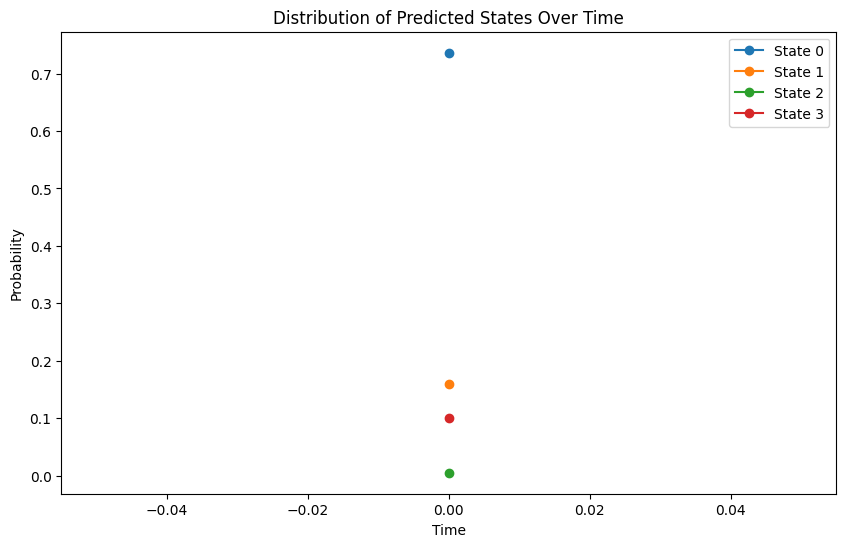

In [28]:
# Plot the distribution of predicted states over time
plt.figure(figsize=(10, 6))
for state in range(hm.n_components):
    state_prob = (predicted_states == state).sum(axis=0) / len(predicted_states)
    plt.plot(state_prob, label=f'State {state}', marker='o')
plt.title('Distribution of Predicted States Over Time')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

